<a href="https://colab.research.google.com/github/KKAARRIIMM15/Cancer-Tumor-instance-segmentation-/blob/main/how_to_train_Segmentation_model_on_cancer_tumor_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## the Author Email  **karimeldeeb2001@gmail.com**
## the Author what's up number  **+201555604511**

**this project shows how to use Computer Vision in medical application**
(You Only Look Once) algorithm version 8 introduce a Segmentation layer which is added after detecting the the bounding box to achieve ability for generating segmentation masks precised on the on the object being deteced

### **Dataset from kaggle**
[link of the Dataset](https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri/data)

In [ ]:

import math

import torch
import torchvision
from torch.nn.functional import cross_entropy, one_hot

import random
import time
!pip install ultralytics
from ultralytics import YOLO
import numpy



def setup_seed():
    random.seed(0)
    numpy.random.seed(0)
    torch.manual_seed(0)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

def scale(coords, shape1, shape2, ratio_pad=None):
    if ratio_pad is None:
        gain = min(shape1[0] / shape2[0], shape1[1] / shape2[1])
        pad = (shape1[1] - shape2[1] * gain) / 2, (shape1[0] - shape2[0] * gain) / 2
    else:
        gain = ratio_pad[0][0]
        pad = ratio_pad[1]

    coords[:, [0, 2]] -= pad[0]
    coords[:, [1, 3]] -= pad[1]
    coords[:, :4] /= gain

    coords[:, 0].clamp_(0, shape2[1])
    coords[:, 1].clamp_(0, shape2[0])
    coords[:, 2].clamp_(0, shape2[1])
    coords[:, 3].clamp_(0, shape2[0])
    return coords


def make_anchors(x, strides, offset=0.5):
    assert x is not None
    anchor_points, stride_tensor = [], []
    for i, stride in enumerate(strides):
        _, _, h, w = x[i].shape
        sx = torch.arange(end=w, dtype=x[i].dtype, device=x[i].device) + offset  # shift x
        sy = torch.arange(end=h, dtype=x[i].dtype, device=x[i].device) + offset  # shift y
        sy, sx = torch.meshgrid(sy, sx)
        anchor_points.append(torch.stack((sx, sy), -1).view(-1, 2))
        stride_tensor.append(torch.full((h * w, 1), stride, dtype=x[i].dtype, device=x[i].device))
    return torch.cat(anchor_points), torch.cat(stride_tensor)


def box_iou(box1, box2):
    (a1, a2), (b1, b2) = box1[:, None].chunk(2, 2), box2.chunk(2, 1)
    intersection = (torch.min(a2, b2) - torch.max(a1, b1)).clamp(0).prod(2)

    # IoU = intersection / (area1 + area2 - intersection)
    box1 = box1.T
    box2 = box2.T

    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])

    return intersection / (area1[:, None] + area2 - intersection)


def wh2xy(x):
    y = x.clone()
    y[..., 0] = x[..., 0] - x[..., 2] / 2  # top left x
    y[..., 1] = x[..., 1] - x[..., 3] / 2  # top left y
    y[..., 2] = x[..., 0] + x[..., 2] / 2  # bottom right x
    y[..., 3] = x[..., 1] + x[..., 3] / 2  # bottom right y
    return y


def non_max_suppression(prediction, conf_threshold=0.25, iou_threshold=0.45):
    nc = prediction.shape[1] - 4
    xc = prediction[:, 4:4 + nc].amax(1) > conf_threshold
    max_wh = 7680
    max_det = 300
    max_nms = 30000

    start = time.time()
    outputs = [torch.zeros((0, 6), device=prediction.device)] * prediction.shape[0]
    for index, x in enumerate(prediction):
        x = x.transpose(0, -1)[xc[index]]
        if not x.shape[0]:
            continue
        box, cls = x.split((4, nc), 1)
        box = wh2xy(box)
        if nc > 1:
            i, j = (cls > conf_threshold).nonzero(as_tuple=False).T
            x = torch.cat((box[i], x[i, 4 + j, None], j[:, None].float()), 1)
        else:  # best class only
            conf, j = cls.max(1, keepdim=True)
            x = torch.cat((box, conf, j.float()), 1)[conf.view(-1) > conf_threshold]
        if not x.shape[0]:  # no boxes
            continue
        x = x[x[:, 4].argsort(descending=True)[:max_nms]]
        c = x[:, 5:6] * max_wh  # classes
        boxes, scores = x[:, :4] + c, x[:, 4]  # boxes (offset by class), scores
        i = torchvision.ops.nms(boxes, scores, iou_threshold)  # NMS
        i = i[:max_det]
        outputs[index] = x[i]
        if (time.time() - start) > 0.5 + 0.05 * prediction.shape[0]:
            break

    return outputs


def smooth(y, f=0.05):

    nf = round(len(y) * f * 2) // 2 + 1
    p = numpy.ones(nf // 2)
    yp = numpy.concatenate((p * y[0], y, p * y[-1]), 0)
    return numpy.convolve(yp, numpy.ones(nf) / nf, mode='valid')  #


def compute_ap(tp, conf, pred_cls, target_cls, eps=1e-16):
    i = numpy.argsort(-conf)
    tp, conf, pred_cls = tp[i], conf[i], pred_cls[i]

    unique_classes, nt = numpy.unique(target_cls, return_counts=True)
    nc = unique_classes.shape[0]
    p = numpy.zeros((nc, 1000))
    r = numpy.zeros((nc, 1000))
    ap = numpy.zeros((nc, tp.shape[1]))
    px, py = numpy.linspace(0, 1, 1000), []
    for ci, c in enumerate(unique_classes):
        i = pred_cls == c
        nl = nt[ci]
        no = i.sum()
        if no == 0 or nl == 0:
            continue

        fpc = (1 - tp[i]).cumsum(0)
        tpc = tp[i].cumsum(0)
        recall = tpc / (nl + eps)
        r[ci] = numpy.interp(-px, -conf[i], recall[:, 0], left=0)
        precision = tpc / (tpc + fpc)
        p[ci] = numpy.interp(-px, -conf[i], precision[:, 0], left=1)
        for j in range(tp.shape[1]):
            m_rec = numpy.concatenate(([0.0], recall[:, j], [1.0]))
            m_pre = numpy.concatenate(([1.0], precision[:, j], [0.0]))
            m_pre = numpy.flip(numpy.maximum.accumulate(numpy.flip(m_pre)))

            x = numpy.linspace(0, 1, 101)
            ap[ci, j] = numpy.trapz(numpy.interp(x, m_rec, m_pre), x)

    f1 = 2 * p * r / (p + r + eps)

    i = smooth(f1.mean(0), 0.1).argmax()
    p, r, f1 = p[:, i], r[:, i], f1[:, i]
    tp = (r * nt).round()
    fp = (tp / (p + eps) - tp).round()
    ap50, ap = ap[:, 0], ap.mean(1)
    m_pre, m_rec = p.mean(), r.mean()
    map50, mean_ap = ap50.mean(), ap.mean()
    return tp, fp, m_pre, m_rec, map50, mean_ap


def strip_optimizer(filename):
    x = torch.load(filename, map_location=torch.device('cpu'))
    x['model'].half()
    for p in x['model'].parameters():
        p.requires_grad = False
    torch.save(x, filename)


def clip_gradients(model, max_norm=10.0):
    parameters = model.parameters()
    torch.nn.utils.clip_grad_norm_(parameters, max_norm=max_norm)


class EMA:
    def __init__(self, model, decay=0.9999, tau=2000, updates=0):
        # Create EMA
        self.ema = copy.deepcopy(model).eval()
        self.updates = updates
        self.decay = lambda x: decay * (1 - math.exp(-x / tau))
        for p in self.ema.parameters():
            p.requires_grad_(False)

    def update(self, model):
        if hasattr(model, 'module'):
            model = model.module
        with torch.no_grad():
            self.updates += 1
            d = self.decay(self.updates)

            msd = model.state_dict()
            for k, v in self.ema.state_dict().items():
                if v.dtype.is_floating_point:
                    v *= d
                    v += (1 - d) * msd[k].detach()


class AverageMeter:
    def __init__(self):
        self.num = 0
        self.sum = 0
        self.avg = 0

    def update(self, v, n):
        if not math.isnan(float(v)):
            self.num = self.num + n
            self.sum = self.sum + v * n
            self.avg = self.sum / self.num


class ComputeLoss:
    def __init__(self, model, params):
        super().__init__()
        if hasattr(model, 'module'):
            model = model.module

        device = next(model.parameters()).device  # get model device

        m = model.head  # Head() module
        self.bce = torch.nn.BCEWithLogitsLoss(reduction='none')
        self.stride = m.stride  # model strides
        self.nc = m.nc  # number of classes
        self.no = m.no
        self.device = device
        self.params = params

        # task aligned assigner
        self.top_k = 10
        self.alpha = 0.5
        self.beta = 6.0
        self.eps = 1e-9

        self.bs = 1
        self.num_max_boxes = 0
        # DFL Loss params
        self.dfl_ch = m.dfl.ch
        self.project = torch.arange(self.dfl_ch, dtype=torch.float, device=device)

    def __call__(self, outputs, targets):
        x = outputs[1] if isinstance(outputs, tuple) else outputs
        output = torch.cat([i.view(x[0].shape[0], self.no, -1) for i in x], 2)
        pred_output, pred_scores = output.split((4 * self.dfl_ch, self.nc), 1)

        pred_output = pred_output.permute(0, 2, 1).contiguous()
        pred_scores = pred_scores.permute(0, 2, 1).contiguous()

        size = torch.tensor(x[0].shape[2:], dtype=pred_scores.dtype, device=self.device)
        size = size * self.stride[0]

        anchor_points, stride_tensor = make_anchors(x, self.stride, 0.5)

        # targets
        if targets.shape[0] == 0:
            gt = torch.zeros(pred_scores.shape[0], 0, 5, device=self.device)
        else:
            i = targets[:, 0]  # image index
            _, counts = i.unique(return_counts=True)
            gt = torch.zeros(pred_scores.shape[0], counts.max(), 5, device=self.device)
            for j in range(pred_scores.shape[0]):
                matches = i == j
                n = matches.sum()
                if n:
                    gt[j, :n] = targets[matches, 1:]
            gt[..., 1:5] = wh2xy(gt[..., 1:5].mul_(size[[1, 0, 1, 0]]))

        gt_labels, gt_bboxes = gt.split((1, 4), 2)  # cls, xyxy
        mask_gt = gt_bboxes.sum(2, keepdim=True).gt_(0)

        # boxes
        b, a, c = pred_output.shape
        pred_bboxes = pred_output.view(b, a, 4, c // 4).softmax(3)
        pred_bboxes = pred_bboxes.matmul(self.project.type(pred_bboxes.dtype))

        a, b = torch.split(pred_bboxes, 2, -1)
        pred_bboxes = torch.cat((anchor_points - a, anchor_points + b), -1)

        scores = pred_scores.detach().sigmoid()
        bboxes = (pred_bboxes.detach() * stride_tensor).type(gt_bboxes.dtype)
        target_bboxes, target_scores, fg_mask = self.assign(scores, bboxes,
                                                            gt_labels, gt_bboxes, mask_gt,
                                                            anchor_points * stride_tensor)

        target_bboxes /= stride_tensor
        target_scores_sum = target_scores.sum()

        # cls loss
        loss_cls = self.bce(pred_scores, target_scores.to(pred_scores.dtype))
        loss_cls = loss_cls.sum() / target_scores_sum

        # box loss
        loss_box = torch.zeros(1, device=self.device)
        loss_dfl = torch.zeros(1, device=self.device)
        if fg_mask.sum():
            # IoU loss
            weight = torch.masked_select(target_scores.sum(-1), fg_mask).unsqueeze(-1)
            loss_box = self.iou(pred_bboxes[fg_mask], target_bboxes[fg_mask])
            loss_box = ((1.0 - loss_box) * weight).sum() / target_scores_sum
            # DFL loss
            a, b = torch.split(target_bboxes, 2, -1)
            target_lt_rb = torch.cat((anchor_points - a, b - anchor_points), -1)
            target_lt_rb = target_lt_rb.clamp(0, self.dfl_ch - 1.01)  # distance (left_top, right_bottom)
            loss_dfl = self.df_loss(pred_output[fg_mask].view(-1, self.dfl_ch), target_lt_rb[fg_mask])
            loss_dfl = (loss_dfl * weight).sum() / target_scores_sum

        loss_cls *= self.params['cls']
        loss_box *= self.params['box']
        loss_dfl *= self.params['dfl']
        return loss_cls + loss_box + loss_dfl  # loss(cls, box, dfl)

    @torch.no_grad()
    def assign(self, pred_scores, pred_bboxes, true_labels, true_bboxes, true_mask, anchors):
        self.bs = pred_scores.size(0)
        self.num_max_boxes = true_bboxes.size(1)

        if self.num_max_boxes == 0:
            device = true_bboxes.device
            return (torch.full_like(pred_scores[..., 0], self.nc).to(device),
                    torch.zeros_like(pred_bboxes).to(device),
                    torch.zeros_like(pred_scores).to(device),
                    torch.zeros_like(pred_scores[..., 0]).to(device),
                    torch.zeros_like(pred_scores[..., 0]).to(device))

        i = torch.zeros([2, self.bs, self.num_max_boxes], dtype=torch.long)
        i[0] = torch.arange(end=self.bs).view(-1, 1).repeat(1, self.num_max_boxes)
        i[1] = true_labels.long().squeeze(-1)

        overlaps = self.iou(true_bboxes.unsqueeze(2), pred_bboxes.unsqueeze(1))
        overlaps = overlaps.squeeze(3).clamp(0)
        align_metric = pred_scores[i[0], :, i[1]].pow(self.alpha) * overlaps.pow(self.beta)
        bs, n_boxes, _ = true_bboxes.shape
        lt, rb = true_bboxes.view(-1, 1, 4).chunk(2, 2)  # left-top, right-bottom
        bbox_deltas = torch.cat((anchors[None] - lt, rb - anchors[None]), dim=2)
        mask_in_gts = bbox_deltas.view(bs, n_boxes, anchors.shape[0], -1).amin(3).gt_(1e-9)
        metrics = align_metric * mask_in_gts
        top_k_mask = true_mask.repeat([1, 1, self.top_k]).bool()
        num_anchors = metrics.shape[-1]
        top_k_metrics, top_k_indices = torch.topk(metrics, self.top_k, dim=-1, largest=True)
        if top_k_mask is None:
            top_k_mask = (top_k_metrics.max(-1, keepdim=True) > self.eps).tile([1, 1, self.top_k])
        top_k_indices = torch.where(top_k_mask, top_k_indices, 0)
        is_in_top_k = one_hot(top_k_indices, num_anchors).sum(-2)
        is_in_top_k = torch.where(is_in_top_k > 1, 0, is_in_top_k)
        mask_top_k = is_in_top_k.to(metrics.dtype)
        mask_pos = mask_top_k * mask_in_gts * true_mask

        fg_mask = mask_pos.sum(-2)
        if fg_mask.max() > 1:
            mask_multi_gts = (fg_mask.unsqueeze(1) > 1).repeat([1, self.num_max_boxes, 1])
            max_overlaps_idx = overlaps.argmax(1)
            is_max_overlaps = one_hot(max_overlaps_idx, self.num_max_boxes)
            is_max_overlaps = is_max_overlaps.permute(0, 2, 1).to(overlaps.dtype)
            mask_pos = torch.where(mask_multi_gts, is_max_overlaps, mask_pos)
            fg_mask = mask_pos.sum(-2)
        target_gt_idx = mask_pos.argmax(-2)

        batch_index = torch.arange(end=self.bs,
                                   dtype=torch.int64,
                                   device=true_labels.device)[..., None]
        target_gt_idx = target_gt_idx + batch_index * self.num_max_boxes
        target_labels = true_labels.long().flatten()[target_gt_idx]
        target_bboxes = true_bboxes.view(-1, 4)[target_gt_idx]
        target_labels.clamp(0)
        target_scores = one_hot(target_labels, self.nc)
        fg_scores_mask = fg_mask[:, :, None].repeat(1, 1, self.nc)
        target_scores = torch.where(fg_scores_mask > 0, target_scores, 0)

        align_metric *= mask_pos
        pos_align_metrics = align_metric.amax(axis=-1, keepdim=True)
        pos_overlaps = (overlaps * mask_pos).amax(axis=-1, keepdim=True)
        norm_align_metric = (align_metric * pos_overlaps / (pos_align_metrics + self.eps)).amax(-2)
        norm_align_metric = norm_align_metric.unsqueeze(-1)
        target_scores = target_scores * norm_align_metric

        return target_bboxes, target_scores, fg_mask.bool()

    @staticmethod
    def df_loss(pred_dist, target):
        tl = target.long()  # target left
        tr = tl + 1  # target right
        wl = tr - target  # weight left
        wr = 1 - wl  # weight right
        l_loss = cross_entropy(pred_dist, tl.view(-1), reduction="none").view(tl.shape)
        r_loss = cross_entropy(pred_dist, tr.view(-1), reduction="none").view(tl.shape)
        return (l_loss * wl + r_loss * wr).mean(-1, keepdim=True)

    @staticmethod
    def iou(box1, box2, eps=1e-7):
        b1_x1, b1_y1, b1_x2, b1_y2 = box1.chunk(4, -1)
        b2_x1, b2_y1, b2_x2, b2_y2 = box2.chunk(4, -1)
        w1, h1 = b1_x2 - b1_x1, b1_y2 - b1_y1 + eps
        w2, h2 = b2_x2 - b2_x1, b2_y2 - b2_y1 + eps

        # Intersection area
        area1 = b1_x2.minimum(b2_x2) - b1_x1.maximum(b2_x1)
        area2 = b1_y2.minimum(b2_y2) - b1_y1.maximum(b2_y1)
        intersection = area1.clamp(0) * area2.clamp(0)

        # Union Area
        union = w1 * h1 + w2 * h2 - intersection + eps

        # IoU
        iou = intersection / union
        cw = b1_x2.maximum(b2_x2) - b1_x1.minimum(b2_x1)
        ch = b1_y2.maximum(b2_y2) - b1_y1.minimum(b2_y1)
        c2 = cw ** 2 + ch ** 2 + eps
        rho2 = ((b2_x1 + b2_x2 - b1_x1 - b1_x2) ** 2 + (b2_y1 + b2_y2 - b1_y1 - b1_y2) ** 2) / 4
        v = (4 / math.pi ** 2) * (torch.atan(w2 / h2) - torch.atan(w1 / h1)).pow(2)
        with torch.no_grad():
            alpha = v / (v - iou + (1 + eps))
        return iou - (rho2 / c2 + v * alpha)  # CIoU



########################################################################################




def pad(k, p=None, d=1):
    if d > 1:
        k = d * (k - 1) + 1
    if p is None:
        p = k // 2
    return p


def fuse_conv(conv, norm):
    fused_conv = torch.nn.Conv2d(conv.in_channels,
                                 conv.out_channels,
                                 kernel_size=conv.kernel_size,
                                 stride=conv.stride,
                                 padding=conv.padding,
                                 groups=conv.groups,
                                 bias=True).requires_grad_(False).to(conv.weight.device)

    w_conv = conv.weight.clone().view(conv.out_channels, -1)
    w_norm = torch.diag(norm.weight.div(torch.sqrt(norm.eps + norm.running_var)))
    fused_conv.weight.copy_(torch.mm(w_norm, w_conv).view(fused_conv.weight.size()))

    b_conv = torch.zeros(conv.weight.size(0), device=conv.weight.device) if conv.bias is None else conv.bias
    b_norm = norm.bias - norm.weight.mul(norm.running_mean).div(torch.sqrt(norm.running_var + norm.eps))
    fused_conv.bias.copy_(torch.mm(w_norm, b_conv.reshape(-1, 1)).reshape(-1) + b_norm)

    return fused_conv


class Conv(torch.nn.Module):
    def __init__(self, in_ch, out_ch, k=1, s=1, p=None, d=1, g=1):
        super().__init__()
        self.conv = torch.nn.Conv2d(in_ch, out_ch, k, s, pad(k, p, d), d, g, False)
        self.norm = torch.nn.BatchNorm2d(out_ch, 0.001, 0.03)
        self.relu = torch.nn.SiLU(inplace=True)

    def forward(self, x):
        return self.relu(self.norm(self.conv(x)))

    def fuse_forward(self, x):
        return self.relu(self.conv(x))


class Residual(torch.nn.Module):
    def __init__(self, ch, add=True):
        super().__init__()
        self.add_m = add
        self.res_m = torch.nn.Sequential(Conv(ch, ch, 3),
                                         Conv(ch, ch, 3))

    def forward(self, x):
        return self.res_m(x) + x if self.add_m else self.res_m(x)


class CSP(torch.nn.Module):
    def __init__(self, in_ch, out_ch, n=1, add=True):
        super().__init__()
        self.conv1 = Conv(in_ch, out_ch // 2)
        self.conv2 = Conv(in_ch, out_ch // 2)
        self.conv3 = Conv((2 + n) * out_ch // 2, out_ch)
        self.res_m = torch.nn.ModuleList(Residual(out_ch // 2, add) for _ in range(n))

    def forward(self, x):
        y = [self.conv1(x), self.conv2(x)]
        y.extend(m(y[-1]) for m in self.res_m)
        return self.conv3(torch.cat(y, dim=1))


class SPP(torch.nn.Module):
    def __init__(self, in_ch, out_ch, k=5):
        super().__init__()
        self.conv1 = Conv(in_ch, in_ch // 2)
        self.conv2 = Conv(in_ch * 2, out_ch)
        self.res_m = torch.nn.MaxPool2d(k, 1, k // 2)

    def forward(self, x):
        x = self.conv1(x)
        y1 = self.res_m(x)
        y2 = self.res_m(y1)
        return self.conv2(torch.cat([x, y1, y2, self.res_m(y2)], 1))


class DarkNet(torch.nn.Module):
    def __init__(self, width, depth):
        super().__init__()
        p1 = [Conv(width[0], width[1], 3, 2)]
        p2 = [Conv(width[1], width[2], 3, 2),
              CSP(width[2], width[2], depth[0])]
        p3 = [Conv(width[2], width[3], 3, 2),
              CSP(width[3], width[3], depth[1])]
        p4 = [Conv(width[3], width[4], 3, 2),
              CSP(width[4], width[4], depth[2])]
        p5 = [Conv(width[4], width[5], 3, 2),
              CSP(width[5], width[5], depth[0]),
              SPP(width[5], width[5])]

        self.p1 = torch.nn.Sequential(*p1)
        self.p2 = torch.nn.Sequential(*p2)
        self.p3 = torch.nn.Sequential(*p3)
        self.p4 = torch.nn.Sequential(*p4)
        self.p5 = torch.nn.Sequential(*p5)

    def forward(self, x):
        p1 = self.p1(x)
        p2 = self.p2(p1)
        p3 = self.p3(p2)
        p4 = self.p4(p3)
        p5 = self.p5(p4)
        return p3, p4, p5


class DarkFPN(torch.nn.Module):
    def __init__(self, width, depth):
        super().__init__()
        self.up = torch.nn.Upsample(None, 2)
        self.h1 = CSP(width[4] + width[5], width[4], depth[0], False)
        self.h2 = CSP(width[3] + width[4], width[3], depth[0], False)
        self.h3 = Conv(width[3], width[3], 3, 2)
        self.h4 = CSP(width[3] + width[4], width[4], depth[0], False)
        self.h5 = Conv(width[4], width[4], 3, 2)
        self.h6 = CSP(width[4] + width[5], width[5], depth[0], False)

    def forward(self, x):
        p3, p4, p5 = x
        h1 = self.h1(torch.cat([self.up(p5), p4], 1))
        h2 = self.h2(torch.cat([self.up(h1), p3], 1))
        h4 = self.h4(torch.cat([self.h3(h2), h1], 1))
        h6 = self.h6(torch.cat([self.h5(h4), p5], 1))
        return h2, h4, h6


class DFL(torch.nn.Module):
    def __init__(self, ch=16):
        super().__init__()
        self.ch = ch
        self.conv = torch.nn.Conv2d(ch, 1, 1, bias=False).requires_grad_(False)
        x = torch.arange(ch, dtype=torch.float).view(1, ch, 1, 1)
        self.conv.weight.data[:] = torch.nn.Parameter(x)

    def forward(self, x):
        b, c, a = x.shape
        x = x.view(b, 4, self.ch, a).transpose(2, 1)
        return self.conv(x.softmax(1)).view(b, 4, a)


class Head(torch.nn.Module):
    anchors = torch.empty(0)
    strides = torch.empty(0)

    def __init__(self, nc=80, filters=()):
        super().__init__()
        self.ch = 16  # DFL channels
        self.nc = nc  # number of classes
        self.nl = len(filters)  # number of detection layers
        self.no = nc + self.ch * 4  # number of outputs per anchor
        self.stride = torch.zeros(self.nl)  # strides computed during build

        c1 = max(filters[0], self.nc)
        c2 = max((filters[0] // 4, self.ch * 4))

        self.dfl = DFL(self.ch)
        self.cls = torch.nn.ModuleList(torch.nn.Sequential(Conv(x, c1, 3),
                                                           Conv(c1, c1, 3),
                                                           torch.nn.Conv2d(c1, self.nc, 1)) for x in filters)
        self.box = torch.nn.ModuleList(torch.nn.Sequential(Conv(x, c2, 3),
                                                           Conv(c2, c2, 3),
                                                           torch.nn.Conv2d(c2, 4 * self.ch, 1)) for x in filters)

    def forward(self, x):
        for i in range(self.nl):
            x[i] = torch.cat((self.box[i](x[i]), self.cls[i](x[i])), 1)
        if self.training:
            return x
        self.anchors, self.strides = (x.transpose(0, 1) for x in make_anchors(x, self.stride, 0.5))

        x = torch.cat([i.view(x[0].shape[0], self.no, -1) for i in x], 2)
        box, cls = x.split((self.ch * 4, self.nc), 1)
        a, b = torch.split(self.dfl(box), 2, 1)
        a = self.anchors.unsqueeze(0) - a
        b = self.anchors.unsqueeze(0) + b
        box = torch.cat(((a + b) / 2, b - a), 1)
        return torch.cat((box * self.strides, cls.sigmoid()), 1)

    def initialize_biases(self):
        # Initialize biases
        m = self
        for a, b, s in zip(m.box, m.cls, m.stride):
            a[-1].bias.data[:] = 1.0  # box
            # cls (.01 objects, 80 classes, 640 img)
            b[-1].bias.data[:m.nc] = math.log(5 / m.nc / (640 / s) ** 2)


class YOLO(torch.nn.Module):
    def __init__(self, width, depth, num_classes):
        super().__init__()
        self.net = DarkNet(width, depth)
        self.fpn = DarkFPN(width, depth)

        img_dummy = torch.zeros(1, 3, 256, 256)
        self.head = Head(num_classes, (width[3], width[4], width[5]))
        self.head.stride = torch.tensor([256 / x.shape[-2] for x in self.forward(img_dummy)])
        self.stride = self.head.stride
        self.head.initialize_biases()

    def forward(self, x):
        x = self.net(x)
        x = self.fpn(x)
        return self.head(list(x))

    def fuse(self):
        for m in self.modules():
            if type(m) is Conv and hasattr(m, 'norm'):
                m.conv = fuse_conv(m.conv, m.norm)
                m.forward = m.fuse_forward
                delattr(m, 'norm')
        return self


def yolo_v8_n(num_classes: int = 80):
    depth = [1, 2, 2]
    width = [3, 16, 32, 64, 128, 256]
    return YOLO(width, depth, num_classes)


def yolo_v8_s(num_classes: int = 80):
    depth = [1, 2, 2]
    width = [3, 32, 64, 128, 256, 512]
    return YOLO(width, depth, num_classes)


def yolo_v8_m(num_classes: int = 80):
    depth = [2, 4, 4]
    width = [3, 48, 96, 192, 384, 576]
    return YOLO(width, depth, num_classes)


def yolo_v8_l(num_classes: int = 80):
    depth = [3, 6, 6]
    width = [3, 64, 128, 256, 512, 512]
    return YOLO(width, depth, num_classes)


def yolo_v8_x(num_classes: int = 80):
    depth = [3, 6, 6]
    width = [3, 80, 160, 320, 640, 640]
    return YOLO(width, depth, num_classes)




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os.path
path = 'drive//MyDrive//Tumor//config2.yaml'
check_file = os.path.isfile(path)

print(check_file)

In [ ]:


def plot_orginal_and_detection( orginal_im , im ):

  orginal_im = cv2.cvtColor(orginal_im, cv2.COLOR_BGR2RGB)

  fig, axs = plt.subplots(1, 2, figsize=(12, 8))  # 1 row, 2 columns

  # Display the original image on the left
  axs[0].imshow(orginal_im)
  axs[0].set_title('Original Image')
  axs[0].axis('off')  # Hide the axes

  # Display the detection result on the right
  axs[1].imshow(im)
  axs[1].set_title('Detection')
  axs[1].axis('off')  # Hide the axes

  plt.subplots_adjust(wspace=1.0)

  # Show the plot
  plt.tight_layout()
  plt.show()


### **this funcation shows how the extract segment of each tumor then perform canny edge detection then find the external contours of the tumor edge**

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def extract_all_segments( new_result ):
  if new_result.masks == None:
    print(" \n No Cancer tumor\n")

  extracted_masks = new_result.masks.data
  detected_boxes = new_result.boxes.data

  i = 0;  conf = [ ];  x1 = [ ];    y1 = [ ]
  while(i < len(detected_boxes) ):
    conf.append(detected_boxes[i][4]);   x1.append(detected_boxes[i][0]);     y1.append(detected_boxes[i][1])
    i=i+1

  class_labels = detected_boxes[:, -1].int().tolist()
  masks_by_class = {name: [] for name in new_result.names.values()}


  for mask, class_id , confdnce in zip(extracted_masks, class_labels, conf):
    if( confdnce > 0.1):
      class_name = new_result.names[class_id]
      masks_by_class[class_name].append(mask.numpy())

  for class_name, masks in masks_by_class.items():
    print(f"Class Name: {class_name}, Number of Masks: {len(masks)}")

  tumorMask = masks_by_class['tumor']
  tumorMask = np.array(tumorMask)

  i = 0
  while(i < len(tumorMask) ):
    TMask = tumorMask[i]
    TMask = TMask.reshape(TMask.shape[0], TMask.shape[1])

    TMask = TMask * 255
    TMask = cv2.resize(TMask, (W, H))
    TMask = TMask.astype(np.uint8)

    edges = cv2.Canny(TMask, 50, 100)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(image, contours, -1, (0, 205, 0), 2)

    '''target_pixel = [0, 0, 0]
    pixel_count = np.sum(np.all(image == target_pixel, axis=-1))
    area = cv2.contourArea(contours[0])
    area = (area / ( (W * H)-pixel_count ) ) * 100;   area = "{:.2f}".format(area);'''

    cv2.putText(image, str(i+1), (int(x1[i] + 20), int(y1[i] - 2)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (20, 230, 20), 1, cv2.LINE_AA)
    i = i + 1

  return image


## **Start Training**

**this path ---> "drive//MyDrive//Tumor//config2.yaml"   contain the training data for each image and its label**

In [ ]:

model = YOLO("yolov8n-seg.yaml")
results = model.train(model="yolov8n-seg.yaml", data="drive//MyDrive//Tumor//config2.yaml", imgsz=1024 ,
                      optimizer="SGD" , epochs=40 ,batch=5, lr0=0.008 , lrf=0.1)


Ultralytics YOLOv8.2.92 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=segment, mode=train, model=yolov8n-seg.yaml, data=drive//MyDrive//Tumor//config2.yaml, epochs=40, time=None, patience=100, batch=5, imgsz=1024, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_c

100%|██████████| 755k/755k [00:00<00:00, 109MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 6.25M/6.25M [00:00<00:00, 315MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/Tumor/dataset/labels/train.cache... 98 images, 0 backgrounds, 0 corrupt: 100%|██████████| 98/98 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/Tumor/dataset/labels/train.cache... 98 images, 0 backgrounds, 0 corrupt: 100%|██████████| 98/98 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.008, momentum=0.937) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005078125), 76 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 2 dataloader workers
Logging results to runs/segment/train
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/40      2.24G       3.24      11.14      5.574      4.276          4       1024: 100%|██████████| 20/20 [00:25<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.64it/s]

                   all         98        173    6.8e-05     0.0116   3.46e-05   1.55e-05          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/40       2.2G      3.292      10.04      5.596      4.284          7       1024: 100%|██████████| 20/20 [00:07<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.61it/s]

                   all         98        173    6.8e-05     0.0116   3.46e-05   1.55e-05          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/40      2.27G      3.377      7.773      5.564      4.242         10       1024: 100%|██████████| 20/20 [00:04<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.62it/s]

                   all         98        173    6.8e-05     0.0116   3.46e-05   1.55e-05          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/40      2.22G      3.224      7.675       5.18      4.235         16       1024: 100%|██████████| 20/20 [00:06<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.91it/s]

                   all         98        173   0.000204     0.0347   0.000107   4.77e-05          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/40      2.25G      3.176      7.425      5.709      4.246          3       1024: 100%|██████████| 20/20 [00:04<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.46it/s]

                   all         98        173   0.000272     0.0462   0.000148   4.14e-05          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/40      2.25G      3.258      6.378      5.537      4.219         10       1024: 100%|██████████| 20/20 [00:05<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.78it/s]


                   all         98        173    0.00116      0.197   0.000855   0.000277   0.000442     0.0751   0.000238   3.94e-05

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/40      2.16G      3.196      5.386      5.257       4.18          8       1024: 100%|██████████| 20/20 [00:06<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]

                   all         98        173    0.00116      0.197    0.00131   0.000305   0.000646       0.11   0.000359   6.59e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/40      2.23G        3.3      5.269      5.149      4.183         10       1024: 100%|██████████| 20/20 [00:06<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.69it/s]

                   all         98        173     0.0015      0.254    0.00128   0.000385   0.000578     0.0983   0.000611   0.000107



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/40      2.22G      3.425      5.169      5.042      4.173         11       1024: 100%|██████████| 20/20 [00:05<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.43it/s]

                   all         98        173    0.00153       0.26   0.000971   0.000287   0.000578     0.0983   0.000345   6.32e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/40       2.2G      3.203      5.036      5.161      4.172          6       1024: 100%|██████████| 20/20 [00:05<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.89it/s]

                   all         98        173    0.00935     0.0116    0.00282   0.000918    0.00467    0.00578    0.00173   0.000175



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/40      2.25G      3.101      4.909      5.515      4.142          4       1024: 100%|██████████| 20/20 [00:07<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.24it/s]

                   all         98        173     0.0217    0.00578     0.0012   0.000214   0.000548    0.00578   2.01e-05   2.01e-06



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/40      2.22G      3.343      4.881      4.936      4.141          8       1024: 100%|██████████| 20/20 [00:04<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.17it/s]

                   all         98        173      0.012    0.00578   0.000481   0.000106   0.000215    0.00578   1.81e-05   5.43e-06



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/40      2.18G      3.167      4.618      4.932      4.108          5       1024: 100%|██████████| 20/20 [00:06<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.37it/s]

                   all         98        173    0.00381     0.0116     0.0005   9.53e-05    0.00229     0.0116   0.000295   5.96e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/40      2.27G      3.417       4.59      4.751      4.087          3       1024: 100%|██████████| 20/20 [00:04<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.94it/s]


                   all         98        173    0.00534     0.0173   0.000928   0.000189    0.00181     0.0116   0.000835   0.000178

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/40      2.29G      3.138      4.532      4.571      4.046          4       1024: 100%|██████████| 20/20 [00:06<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.65it/s]

                   all         98        173     0.0235    0.00578    0.00111   0.000221    0.00233    0.00578   0.000491   9.93e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/40      2.24G      3.185      4.305      4.358       4.01         14       1024: 100%|██████████| 20/20 [00:04<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.77it/s]


                   all         98        173    0.00156      0.266    0.00107   0.000311    0.00109      0.185   0.000705   0.000185

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/40      2.33G       3.16      4.292      4.369      3.995          4       1024: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]

                   all         98        173     0.0019      0.324    0.00148   0.000456    0.00889    0.00578    0.00265   0.000525



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/40      2.18G      2.995      4.358      4.235      3.921         14       1024: 100%|██████████| 20/20 [00:04<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.96it/s]

                   all         98        173     0.0291     0.0231    0.00619    0.00187     0.0304     0.0231    0.00578    0.00223



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/40      2.18G      3.072      4.166      4.139      3.929          5       1024: 100%|██████████| 20/20 [00:07<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.02it/s]

                   all         98        173    0.00255      0.434      0.019    0.00538    0.00204      0.347     0.0177    0.00623



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/40      2.18G      3.261      4.352      3.902      3.881          6       1024: 100%|██████████| 20/20 [00:04<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]

                   all         98        173    0.00262      0.445     0.0113    0.00304    0.00231      0.393     0.0142    0.00386



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      21/40       2.3G       3.24      4.305      3.869      3.854          5       1024: 100%|██████████| 20/20 [00:07<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.96it/s]

                   all         98        173    0.00303      0.514     0.0561     0.0195    0.00276      0.468     0.0617     0.0195



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      22/40      2.18G      3.126      4.292      3.824      3.793         11       1024: 100%|██████████| 20/20 [00:04<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.90it/s]

                   all         98        173     0.0328       0.15     0.0417      0.012     0.0391      0.179     0.0487     0.0165



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      23/40      2.24G      3.107       4.22       3.62      3.741         14       1024: 100%|██████████| 20/20 [00:08<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.56it/s]

                   all         98        173      0.189       0.11     0.0559     0.0152      0.209      0.121     0.0626     0.0224



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      24/40      2.22G      2.991      4.112      3.772      3.738          7       1024: 100%|██████████| 20/20 [00:05<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.42it/s]

                   all         98        173      0.217     0.0867     0.0496     0.0145       0.26     0.0983     0.0611     0.0265



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      25/40      2.21G      3.078      4.119      3.783      3.675          8       1024: 100%|██████████| 20/20 [00:04<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.10it/s]


                   all         98        173      0.369     0.0642     0.0915     0.0261      0.435     0.0757        0.1     0.0385

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      26/40       2.2G      3.066      3.958      3.649      3.633          5       1024: 100%|██████████| 20/20 [00:06<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.39it/s]

                   all         98        173      0.221     0.0289     0.0612       0.02       0.31     0.0405     0.0687     0.0304



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      27/40      2.21G      3.092       4.11      3.579      3.637          6       1024: 100%|██████████| 20/20 [00:04<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.20it/s]


                   all         98        173      0.529     0.0405     0.0671     0.0219      0.604     0.0462     0.0767     0.0388

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      28/40      2.21G      3.139      3.904      3.687      3.646          8       1024: 100%|██████████| 20/20 [00:06<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.83it/s]

                   all         98        173      0.286       0.11     0.0934     0.0329      0.348      0.127       0.11     0.0536



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      29/40      2.24G      3.136      3.758      3.533      3.581          3       1024: 100%|██████████| 20/20 [00:04<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.22it/s]


                   all         98        173      0.309       0.11      0.138     0.0405      0.475      0.156      0.177     0.0886

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      30/40      2.31G      3.143      4.067       3.55      3.601         23       1024: 100%|██████████| 20/20 [00:10<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.98it/s]

                   all         98        173       0.22      0.121      0.108     0.0415      0.221      0.168      0.124     0.0627


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      31/40      2.16G      2.847       4.38      3.999      3.672          3       1024: 100%|██████████| 20/20 [00:06<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.60it/s]

                   all         98        173      0.118     0.0983     0.0889     0.0226      0.171      0.133     0.0995     0.0449



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      32/40       2.2G      2.821      4.098      3.799       3.61          5       1024: 100%|██████████| 20/20 [00:07<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.09it/s]

                   all         98        173       0.15     0.0751     0.0487     0.0135      0.153     0.0251     0.0648      0.024



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      33/40      2.17G       2.73      4.046      3.671      3.581          4       1024: 100%|██████████| 20/20 [00:05<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.59it/s]

                   all         98        173      0.191     0.0578     0.0483     0.0143      0.245     0.0636     0.0651     0.0253



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      34/40      2.17G      2.737      3.981      3.656      3.544          5       1024: 100%|██████████| 20/20 [00:05<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.11it/s]

                   all         98        173      0.241     0.0462     0.0576     0.0145      0.307      0.059     0.0787     0.0262



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      35/40       2.2G      2.654      3.808      3.488       3.46          5       1024: 100%|██████████| 20/20 [00:05<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.54it/s]

                   all         98        173      0.176       0.11     0.0956     0.0319      0.234      0.121      0.121     0.0589



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      36/40      2.15G       2.73      3.909      3.588      3.543          6       1024: 100%|██████████| 20/20 [00:05<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.93it/s]

                   all         98        173      0.232      0.184      0.122     0.0493      0.247      0.195       0.14     0.0714



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      37/40      2.17G      2.646      3.883      3.437      3.401          5       1024: 100%|██████████| 20/20 [00:05<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.53it/s]

                   all         98        173      0.292       0.22      0.149     0.0574      0.301      0.231      0.169     0.0819



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      38/40      2.17G      2.606      3.711      3.411      3.428         10       1024: 100%|██████████| 20/20 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.11it/s]

                   all         98        173      0.311      0.225      0.177      0.069      0.342      0.243      0.194     0.0992



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      39/40      2.22G      2.566        3.7      3.338      3.341          3       1024: 100%|██████████| 20/20 [00:07<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]

                   all         98        173      0.413      0.203      0.182     0.0743      0.437      0.215      0.207      0.106



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      40/40       2.2G      2.703      4.014      3.468        3.5          5       1024: 100%|██████████| 20/20 [00:05<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.97it/s]

                   all         98        173      0.344      0.249      0.176     0.0786       0.36       0.26      0.204      0.106



40 epochs completed in 0.119 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 6.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 6.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.2.92 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-seg summary (fused): 195 layers, 3,258,259 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.52it/s]


                   all         98        173      0.351      0.249      0.174      0.077      0.367       0.26      0.202      0.105
Speed: 1.5ms preprocess, 9.6ms inference, 0.0ms loss, 6.7ms postprocess per image
Results saved to runs/segment/train


In [ ]:
/content/runs/segment/train/weights/last.pt

### **Prediction Phase**


0: 640x640 4 tumors, 209.5ms
Speed: 3.8ms preprocess, 209.5ms inference, 10.9ms postprocess per image at shape (1, 3, 640, 640)
Class Name: tumor, Number of Masks: 4


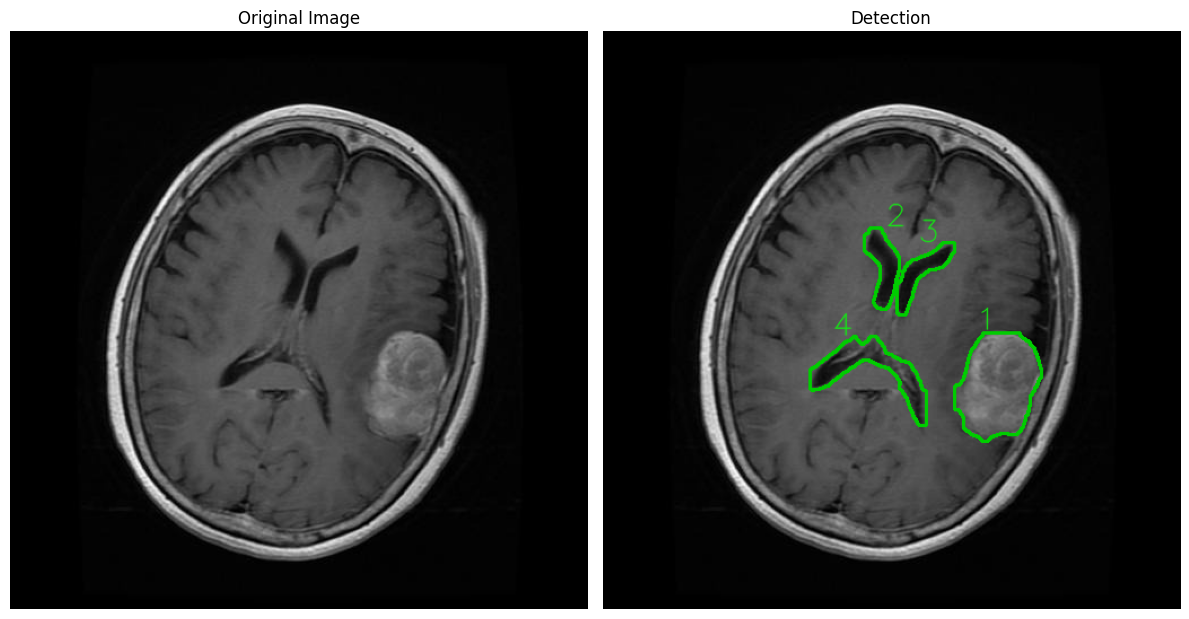

In [ ]:
from ultralytics import YOLO

model = YOLO("drive//MyDrive//Tumor//cancer_tumor.pt")
image = cv2.imread( "drive//MyDrive//Tumor//dataset//images//train//Tr-me_0323.jpg" )
H, W, _ = image.shape

new_result = model.predict(image)[0]
img = extract_all_segments( new_result )

image = cv2.imread( "drive//MyDrive//Tumor//dataset//images//train//Tr-me_0323.jpg" )
plot_orginal_and_detection( image , img )



0: 640x640 2 tumors, 194.1ms
Speed: 3.4ms preprocess, 194.1ms inference, 5.4ms postprocess per image at shape (1, 3, 640, 640)
Class Name: tumor, Number of Masks: 2


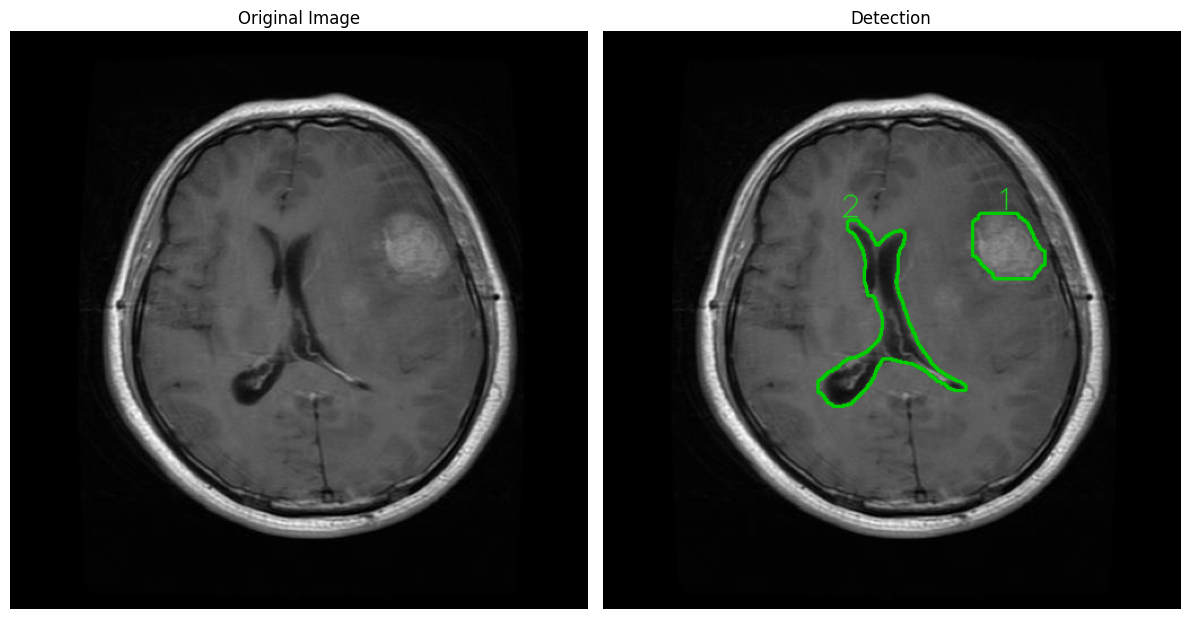

In [ ]:
image = cv2.imread( "drive//MyDrive//Tumor//dataset//images//train//Tr-me_0040.jpg" )
H, W, _ = image.shape

new_result = model.predict(image)[0]
img = extract_all_segments( new_result )

image = cv2.imread( "drive//MyDrive//Tumor//dataset//images//train//Tr-me_0040.jpg" )
plot_orginal_and_detection( image , img )


0: 640x640 3 tumors, 215.6ms
Speed: 4.1ms preprocess, 215.6ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 640)
Class Name: tumor, Number of Masks: 3


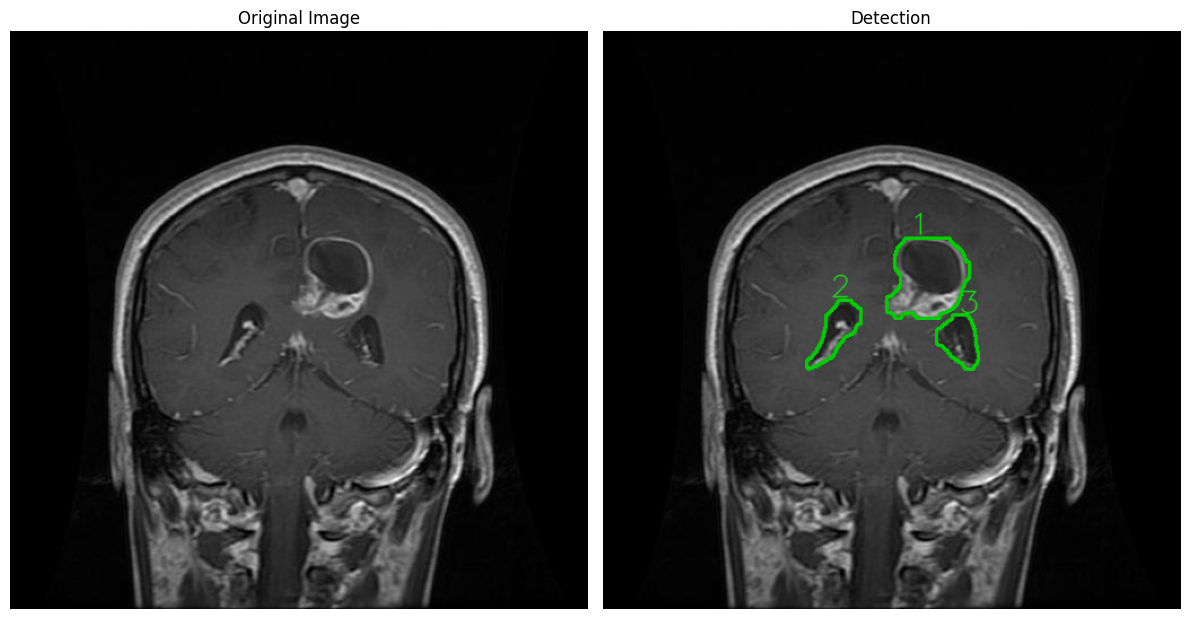

In [ ]:
image = cv2.imread( "drive//MyDrive//Tumor//dataset//images//train//Tr-gl_0586.jpg" )
H, W, _ = image.shape

new_result = model.predict(image)[0]
img = extract_all_segments( new_result )

image = cv2.imread( "drive//MyDrive//Tumor//dataset//images//train//Tr-gl_0586.jpg" )
plot_orginal_and_detection( image , img )

### **Why YOLO algorithm for Brain Tumor Detection?**

**1- Fast object detection:** YOLO is designed for real-time object detection. This makes it highly efficient in identifying brain tumors in the very low hardware resources machines, which is crucial in medical applications where time is important with limmited resources computers unlike the two stage algorthims as the familly of R-CNN that has high number of parameters which make it heavy algorithms.


**2- Localization:** YOLO's streamlined architecture allows it to detect tumors with high precision, even when they vary in size, shape, light condition or location within the brain, making it a reliable tool for medical imaging tasks.